## Importar

In [1]:
import numpy as np
import pandas as pd
import os 
import sys
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV
import optuna
import optuna.visualization as vis
from catboost import CatBoostClassifier

from Classes.dataframe_manager import DataFrameManager

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
import time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

c:\Users\juano\anaconda3\envs\EnsamblesCatBoost\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Leer datos

In [2]:
# Asegurar que el directorio del proyecto esté en sys.path
project_root = os.getcwd()
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
# Carga de dataframes utilizando la clase DataFrameManager
manager = DataFrameManager()
manager.load_multiple([
    'features_upsampled',
    'features_valid',
    'features_upsampled_ord',
    'features_valid_ord',
    'target_upsampled',
    'target_valid',
    'target_upsampled_ord',
    'target_valid_ord'
])

DataFrame 'features_upsampled' cargado exitosamente en el administrador.
DataFrame 'features_valid' cargado exitosamente en el administrador.
DataFrame 'features_upsampled_ord' cargado exitosamente en el administrador.
DataFrame 'features_valid_ord' cargado exitosamente en el administrador.
DataFrame 'target_upsampled' cargado exitosamente en el administrador.
DataFrame 'target_valid' cargado exitosamente en el administrador.
DataFrame 'target_upsampled_ord' cargado exitosamente en el administrador.
DataFrame 'target_valid_ord' cargado exitosamente en el administrador.


In [4]:
# Asignar cada dataframe a una variable con su nombre para utilizarla en el notebook

features_upsampled = manager.get_dataframe('features_upsampled')
features_valid = manager.get_dataframe('features_valid')
features_upsampled_ord = manager.get_dataframe('features_upsampled_ord')
features_valid_ord = manager.get_dataframe('features_valid_ord')
target_upsampled = manager.get_dataframe('target_upsampled')
target_valid = manager.get_dataframe('target_valid')
target_upsampled_ord = manager.get_dataframe('target_upsampled_ord')
target_valid_ord = manager.get_dataframe('target_valid_ord')

## Creación de modelos

### Regresión logística

#### Busqueda en cuadrícula de hiperparámetros

In [5]:
# Definir los valores de cuadrícula de los hiperparámetros
dual = [True, False]
max_iter = [10000, 15000, 20000, 25000, 30000]
param_grid = dict(dual=dual, max_iter=max_iter)

In [6]:
# Crear modelo
model_lr = LogisticRegression(penalty='l2', 
                              solver='liblinear',
                              random_state=12345)

# Crear cuadrícula
grid = GridSearchCV(estimator=model_lr, 
                    param_grid=param_grid,
                    cv=5)

In [7]:
# Convierte a 1D si era 2D
target_upsampled = target_upsampled.squeeze()

# Entrenar modelo
start_time = time.time()
grid_result = grid.fit(features_upsampled, target_upsampled)
probabilities_valid = grid_result.predict_proba(features_valid)[:, 1]
# probabilities_one_valid = probabilities_valid
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid)
auc_roc_lr_grid = roc_auc_score(target_valid, probabilities_valid)
print('El AUC-ROC score al usar la busqueda en cuadrícula y validación cruzada fue de :', auc_roc_lr_grid)
print('Tiempo de ejecución:' + str((time.time() - start_time)) + 'ms')

El AUC-ROC score al usar la busqueda en cuadrícula y validación cruzada fue de : 0.8614772727272728
Tiempo de ejecución:1.3148696422576904ms


#### Busqueda aleatorio de hiperparámetros

In [8]:
model_lr_random = RandomizedSearchCV(estimator=model_lr, param_distributions=param_grid, cv=5)
# Convierte a 1D si era 2D
target_upsampled = target_upsampled.squeeze()
# Entrenar modelo
start_time = time.time()
grid_result_rdm = grid.fit(features_upsampled, target_upsampled)
probabilities_valid_rdm = grid_result_rdm.predict_proba(features_valid)[:, 1]
# probabilities_one_valid_rdm = probabilities_valid_rdm
fpr_rdm, tpr_rdm, thresholds_rdm = roc_curve(
    target_valid, probabilities_valid_rdm)
auc_roc_lr_rdm = roc_auc_score(target_valid, probabilities_valid_rdm)
print('El AUC-ROC score al usar la busqueda en cuadrícula y validación cruzada fue de :', auc_roc_lr_rdm)
print('Tiempo de ejecución:' + str((time.time() - start_time)) + 'ms')

El AUC-ROC score al usar la busqueda en cuadrícula y validación cruzada fue de : 0.8614772727272728
Tiempo de ejecución:1.2762925624847412ms


#### Gráfico comparativo

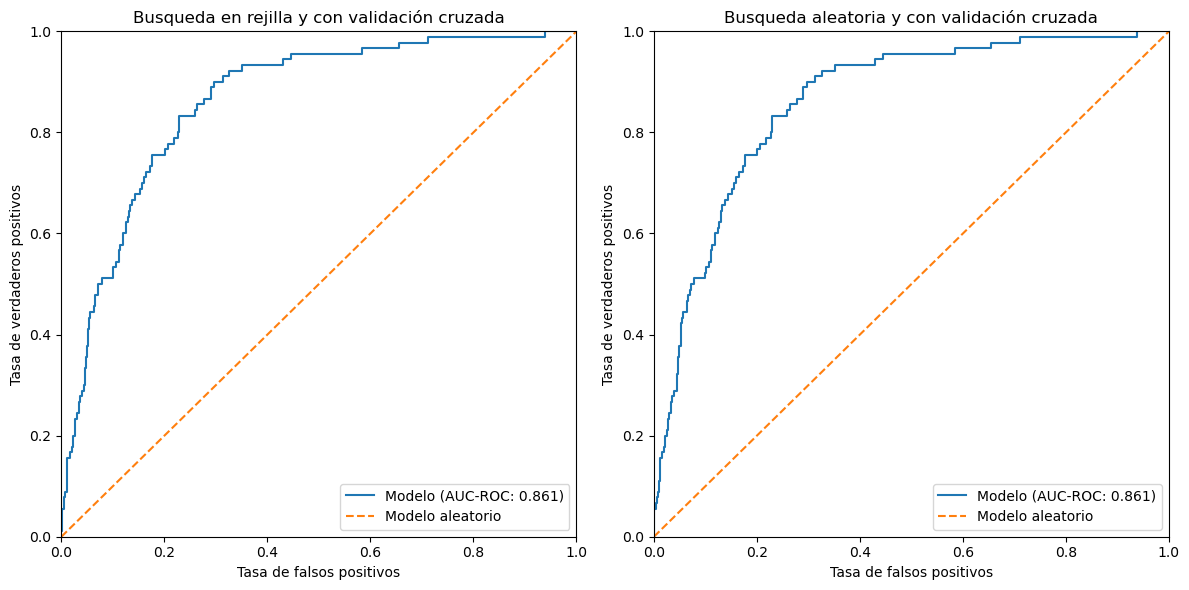

In [9]:
# Crear una figura con una fila y dos columnas
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico 1: Busqueda en rejilla
axes[0].plot(fpr, tpr,  
             label=f'Modelo (AUC-ROC: {auc_roc_lr_grid:.3f})')
axes[0].plot([0, 1], [0, 1], linestyle='--', label='Modelo aleatorio')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.0])
axes[0].set_xlabel('Tasa de falsos positivos')
axes[0].set_ylabel('Tasa de verdaderos positivos')
axes[0].set_title('Busqueda en rejilla y con validación cruzada')
axes[0].legend()

# Gráfico 2: Busqueda aleatoria
axes[1].plot(fpr_rdm, tpr_rdm, 
             label=f'Modelo (AUC-ROC: {auc_roc_lr_rdm:.3f})')
axes[1].plot([0, 1], [0, 1], linestyle='--', label='Modelo aleatorio')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.0])
axes[1].set_xlabel('Tasa de falsos positivos')
axes[1].set_ylabel('Tasa de verdaderos positivos')
axes[1].set_title('Busqueda aleatoria y con validación cruzada')
axes[1].legend()

# Ajustar espacio entre subgráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

El AUC-ROC es el mismo tanto en la busqueda en rejilla como en la aleatoria, sin embargo, la optimización de hiperparámetros de forma aleatoria permite llegar al mismo resultado 0.02 segundos antes.

### Bosque aleatorio de clasificación

#### Optimización de hiperparámetros

##### Sin validación cruzada

In [10]:
# Creación del modelo de Bosque Aleatorio simple
rfc = RandomForestClassifier(random_state=12345)
target_upsampled_ord = target_upsampled_ord.squeeze()  # Convertir de 2D a 1D

start_time = time.time()
rfc.fit(features_upsampled_ord, target_upsampled_ord)

# Obtener las probabilidades predichas para la clase positiva en el conjunto de entrenamiento
rfc_pred = rfc.predict(features_upsampled_ord)
rfc_probabilities_train = rfc.predict_proba(features_upsampled_ord)[:, 1]

# Calcular la curva ROC
fpr_rfc, tpr_rfc, thresholds = roc_curve(
    target_upsampled_ord, rfc_probabilities_train)

# Calcular el AUC-ROC y ACC
auc_score_rfc_train = roc_auc_score(target_upsampled_ord, rfc_probabilities_train)
acc_score_rfc_train = accuracy_score(target_upsampled_ord, rfc_pred)
print('El AUC-ROC score usando el conjunto de entrenamiento sin CV es:',
      auc_score_rfc_train)
print('El accuracy score usando el conjunto de entrenamiento sin CV es:',
      acc_score_rfc_train)
print('Tiempo de ejecución:' + str((time.time() - start_time)) + 'ms')

El AUC-ROC score usando el conjunto de entrenamiento sin CV es: 1.0
El accuracy score usando el conjunto de entrenamiento sin CV es: 1.0
Tiempo de ejecución:0.5005660057067871ms


In [11]:
# Obtener las probabilidades predichas para la clase positiva en el conjunto de validación
rfc_pred_valid = rfc.predict(features_valid_ord)
rfc_probabilities_valid = rfc.predict_proba(features_valid_ord)[:, 1]

# Calcular la curva ROC
fpr_rfc, tpr_rfc, thresholds = roc_curve(
    target_valid_ord, rfc_probabilities_valid)

# Calcular el AUC-ROC
auc_score_rfc = roc_auc_score(target_valid_ord, rfc_probabilities_valid)
acc_score_rfc = accuracy_score(target_valid_ord, rfc_pred_valid)
print('El AUC-ROC score usando el conjunto de validación sin CV :', auc_score_rfc)
print('El accuracy score usando el conjunto de validación sin CV es:', acc_score_rfc)
print('Tiempo de ejecución:' + str((time.time() - start_time)) + 'ms')

El AUC-ROC score usando el conjunto de validación sin CV : 0.8865530303030305
El accuracy score usando el conjunto de validación sin CV es: 0.9298969072164949
Tiempo de ejecución:0.5502300262451172ms


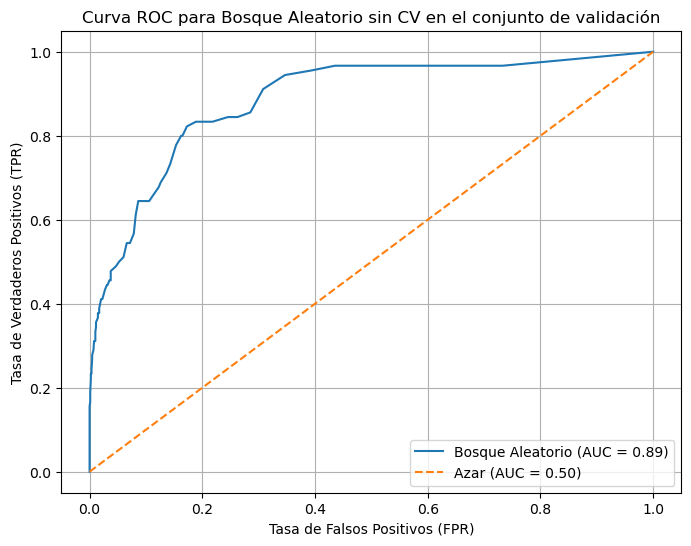

In [12]:
# # Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rfc, tpr_rfc, 
         label=f'Bosque Aleatorio (AUC = {auc_score_rfc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', 
         label='Azar (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para Bosque Aleatorio sin CV en el conjunto de validación')
plt.legend(loc='lower right')
plt.grid()
plt.show()

##### Con validación cruzada

#### GridSearchCV

In [13]:
# Definir hiperparámetros a tunear
forest_params = [
    {'max_depth': list(range(1, 10)),
     'n_estimators': list(range(1, 50)),
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 4]}
]

In [14]:
# Configurar GridSearchCV con la métrica de evaluación AUC-ROC
clf = GridSearchCV(
    rfc,
    forest_params,
    cv=5,
    scoring={'roc_auc': 'roc_auc', 'accuracy': 'accuracy'}, 
    refit='roc_auc',
    error_score='raise'
    )

# Entrenar el modelo con GridSearchCV
start_time = time.time()
clf.fit(features_upsampled_ord, target_upsampled_ord)

# Obtener las probabilidades predichas para la clase positiva en el conjunto de entrenamiento
clf_probabilities_train = clf.predict_proba(features_upsampled_ord)[:, 1]
clf_pred = clf.predict(features_upsampled_ord)

# Calcular la curva ROC
fpr_clf, tpr_clf, thresholds = roc_curve(
    target_upsampled_ord, clf_probabilities_train)

# Calcular el AUC-ROC y accuracy
auc_score_clf_train = roc_auc_score(
    target_upsampled_ord, clf_probabilities_train)
acc_score_clf_train = accuracy_score(
    target_upsampled_ord, clf_pred)

print(f"Mejor valor para max_depth: {clf.best_params_['max_depth']}")
print(f"Mejor valor para n_estimators: {clf.best_params_['n_estimators']}")
print(f"Mejor estimador: {clf.best_estimator_}")
print(f"Mejor puntuación de AUC-ROC: {clf.best_score_}")
print(f"Mehor accuracy score: {acc_score_clf_train}")
print('Tiempo de ejecución:' + str((time.time() - start_time)) + 'ms')

Mejor valor para max_depth: 9
Mejor valor para n_estimators: 46
Mejor estimador: RandomForestClassifier(max_depth=9, n_estimators=46, random_state=12345)
Mejor puntuación de AUC-ROC: 0.9894462879039247
Mehor accuracy score: 0.9498971770424378
Tiempo de ejecución:1329.047966003418ms


In [15]:
# Creación de modelo con mejores hiperparámetros
clf = RandomForestClassifier(
    max_depth=9, 
    n_estimators=46, 
    random_state=12345
)

# Entrenamiento del modelo con los mejores hiperparámetros
start_time = time.time()
clf.fit(features_upsampled_ord, target_upsampled_ord)
probabilities_valid_clf = clf.predict_proba(features_valid_ord)[:,1]
pred_valid_clf = clf.predict(features_valid_ord)

# Calcular la curva ROC
fpr_clf, tpr_clf, thresholds = roc_curve(
    target_valid_ord, probabilities_valid_clf)

# Calcular el AUC-ROC y accuracy
auc_score_clf = roc_auc_score(target_valid_ord, probabilities_valid_clf)
acc_score_clf = accuracy_score(target_valid_ord, pred_valid_clf)

print('El AUC-ROC score  en el conjunto de valiadción  usando hiperparámetros optimizados :', auc_score_clf)
print('El accuracy score en el conjunto de validación usando hiperparámetros optimizados :', acc_score_clf)
print('Tiempo de ejecución:' + str((time.time() - start_time)) + 'ms')

El AUC-ROC score  en el conjunto de valiadción  usando hiperparámetros optimizados : 0.8854356060606061
El accuracy score en el conjunto de validación usando hiperparámetros optimizados : 0.8793814432989691
Tiempo de ejecución:0.15738224983215332ms


#### Optuna

In [36]:

class ModelOptimization:
    '''
    Creación de clase para tunear hiperparámetros utilizando Optuna
    '''

    def __init__(self, features_train, features_valid, target_train, target_valid):
        self.features_train = features_train
        self.features_valid = features_valid
        self.target_train = target_train
        self.target_valid = target_valid
        self.best_auc_score_train = None
        self.best_acc_score_train = None
        self.best_acc_score = None

    def objective(self, trial):
        # Definir los hiperparámetros a optimizar
        max_depth = trial.suggest_int('max_depth', 1, 10)
        n_estimators = trial.suggest_int('n_estimators', 1, 50)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
        
        # Crear el modelo con los hiperparámetros sugeridos
        model = RandomForestClassifier(
            max_depth=max_depth, 
            n_estimators=n_estimators, 
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=12345)

        # Entrenar el modelo
        model.fit(self.features_train, self.target_train)
        
        #Predecir probabilidades en el conjunto de entrenamiento
        pred_train_proba = model.predict_proba(self.features_train)[:, 1]
        pred_train = model.predict(self.features_train)

        # Predecir probabilidades en el conjunto de validación
        predictions_valid_proba = model.predict_proba(self.features_valid)[:, 1]
        pred_valid = model.predict(self.features_valid)

        # Calcular el AUC-ROC y accuracy
        auc_score = roc_auc_score(self.target_valid, predictions_valid_proba)
        acc_score = accuracy_score(self.target_valid, pred_valid)
        auc_score_train = roc_auc_score(self.target_train, pred_train_proba)
        acc_score_train = accuracy_score(self.target_train, pred_train)

        # Almacenar otros valores como atributos de la clase 
        self.best_auc_score_train = auc_score_train 
        self.best_acc_score_train = acc_score_train 
        self.best_acc_score = acc_score
        
        return auc_score

In [37]:
# Para ejecutar Optuna
def optimize_model(features_train, features_valid, target_train, target_valid, n_trials=50):
    optimizer = ModelOptimization(
        features_train, 
        features_valid, 
        target_train, 
        target_valid
    )
    study = optuna.create_study(direction='maximize')  # Maximizar el AUC-ROC
    study.optimize(optimizer.objective, n_trials=n_trials)

    print(f"Mejores parámetros: {study.best_params}")
    print(f"Mejor AUC-ROC score en el conjunto de validación: {study.best_value:.4f}")
    print(f"Mejor accuracy score en el conjunto de validación: {optimizer.best_acc_score:.4f}")
    print(f"Mejor AUC-ROC score en el conjunto de entrenamiento: {optimizer.best_auc_score_train:.4f}")
    print(f"Mejor accuracy score en el conjunto de entrenamiento: {optimizer.best_acc_score_train:.4f}")

    return study

In [38]:
# Ejecutar la optimización
start_time = time.time()
study = optimize_model(features_upsampled_ord, features_valid_ord,
                       target_upsampled_ord, target_valid_ord, n_trials=4000)
print('Tiempo de ejecución:' + str((time.time() - start_time)) + 'ms')


[I 2025-01-09 14:07:44,835] A new study created in memory with name: no-name-0aa24ad7-f204-42da-91a3-f39a1668ed28
[I 2025-01-09 14:07:44,913] Trial 0 finished with value: 0.8818118686868688 and parameters: {'max_depth': 9, 'n_estimators': 18, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8818118686868688.
[I 2025-01-09 14:07:44,990] Trial 1 finished with value: 0.872114898989899 and parameters: {'max_depth': 9, 'n_estimators': 16, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8818118686868688.
[I 2025-01-09 14:07:45,077] Trial 2 finished with value: 0.8927777777777779 and parameters: {'max_depth': 5, 'n_estimators': 38, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8927777777777779.
[I 2025-01-09 14:07:45,148] Trial 3 finished with value: 0.8877146464646465 and parameters: {'max_depth': 4, 'n_estimators': 21, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.89277

Mejores parámetros: {'max_depth': 7, 'n_estimators': 24, 'min_samples_split': 7, 'min_samples_leaf': 4}
Mejor AUC-ROC score en el conjunto de validación: 0.8980
Mejor accuracy score en el conjunto de validación: 0.8454
Mejor AUC-ROC score en el conjunto de entrenamiento: 0.9617
Mejor accuracy score en el conjunto de entrenamiento: 0.8949
Tiempo de ejecución:1293.4450886249542ms


In [24]:
# Graficar el historial de optimización

vis.plot_optimization_history(study).show()

#### Potenciación de gradiente

In [50]:
# Crear el modelo de CatBoost
model_cat = CatBoostClassifier(
    learning_rate=0.02,
    depth=7,
    random_seed=12345,
    iterations=4000,
    loss_function='Logloss',  # Pérdida adecuada para clasificación binaria
    eval_metric='AUC',        # Métrica de evaluación correcta
    verbose=200
)

In [52]:
# Entrenar el modelo
model_cat.fit(features_upsampled_ord, target_upsampled_ord, cat_features=None)

# Obtener probabilidades sobre el conjunto de entrenamiento
pred_train_proba = model_cat.predict_proba(features_upsampled_ord)[:, 1]
pred_train = model_cat.predict(features_upsampled_ord)

# Obtener probabilidades sobre el conjunto de validación
preds_proba = model_cat.predict_proba(features_valid_ord)[:, 1]
pred = model_cat.predict(features_valid_ord)

# Calcular AUC-ROC
auc_score_cat = roc_auc_score(target_valid_ord, preds_proba)
acc_score_cat = accuracy_score(target_valid_ord, pred)
auc_score_train_cat = roc_auc_score(target_upsampled_ord, pred_train_proba)
acc_score_train_cat = accuracy_score(target_upsampled_ord, pred_train)

print()
print(f"Mejor AUC-ROC score en el conjunto de validación: {auc_score_cat:.4f}")
print(f"Mejor accuracy score en el conjunto de validación: {acc_score_cat:.4f}")
print(f"Mejor AUC-ROC score en el conjunto de entrenamiento: {auc_score_train_cat:.4f}")
print(f"Mejor accuracy score en el conjunto de entrenamiento: {acc_score_train_cat:.4f}")

0:	total: 5.32ms	remaining: 21.3s
200:	total: 866ms	remaining: 16.4s
400:	total: 1.73s	remaining: 15.5s
600:	total: 2.53s	remaining: 14.3s
800:	total: 3.33s	remaining: 13.3s
1000:	total: 4.12s	remaining: 12.3s
1200:	total: 4.92s	remaining: 11.5s
1400:	total: 5.81s	remaining: 10.8s
1600:	total: 6.75s	remaining: 10.1s
1800:	total: 7.87s	remaining: 9.61s
2000:	total: 9.29s	remaining: 9.28s
2200:	total: 10.4s	remaining: 8.53s
2400:	total: 11.6s	remaining: 7.74s
2600:	total: 12.8s	remaining: 6.89s
2800:	total: 14s	remaining: 5.98s
3000:	total: 14.9s	remaining: 4.97s
3200:	total: 15.8s	remaining: 3.95s
3400:	total: 16.6s	remaining: 2.93s
3600:	total: 17.6s	remaining: 1.95s
3800:	total: 18.6s	remaining: 976ms
3999:	total: 19.8s	remaining: 0us

Mejor AUC-ROC score en el conjunto de validación: 0.8808
Mejor accuracy score en el conjunto de validación: 0.9299
Mejor AUC-ROC score en el conjunto de entrenamiento: 1.0000
Mejor accuracy score en el conjunto de entrenamiento: 1.0000


#### CatBoost y Optuna

In [57]:
# Definir el número de iteraciones para early stopping
early_stopping_rounds = 50  # Número de iteraciones consecutivas sin mejora permitidas

def optuna_catboost(trial):
    # Definir los hiperparámetros que Optuna optimizará
    param = {
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.02, step=0.001),
        'depth': trial.suggest_int('depth', 7, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 5.5, step=0.5),
        'grow_policy': 'Depthwise',
        'iterations': 4000,
        'use_best_model': True,
        'eval_metric': 'AUC',
        'loss_function': 'Logloss',
        'od_type': 'Iter',
        'od_wait': early_stopping_rounds,
        'random_state': 12345,
        'logging_level': 'Silent'
    }

    # Inicializar el modelo de clasificación con los hiperparámetros definidos
    cat_classifier = CatBoostClassifier(**param)

    # Configurar la validación cruzada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

    auc_scores = []

    # Iterar sobre cada fold de la validación cruzada
    for train_idx, valid_idx in cv.split(features_upsampled_ord, target_upsampled_ord):
        X_train, X_valid = features_upsampled_ord.iloc[train_idx], features_upsampled_ord.iloc[valid_idx]
        y_train, y_valid = target_upsampled_ord.iloc[train_idx], target_upsampled_ord.iloc[valid_idx]

        # Entrenar el modelo con early stopping
        cat_classifier.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            early_stopping_rounds=early_stopping_rounds,
            verbose=False  # Silenciar la salida durante el entrenamiento
        )

    # Predecir probabilidades en el conjunto de validación
    preds_proba = cat_classifier.predict_proba(features_valid_ord)[:, 1]

    # Calcular el AUC-ROC para el conjunto de validación
    auc_valid = roc_auc_score(target_valid_ord, preds_proba)
    auc_scores.append(auc_valid)

    # Calcular el promedio del AUC-ROC a través de todos los folds
    mean_auc = np.mean(auc_scores)

    return mean_auc


In [58]:
# Configurar y ejecutar el estudio de Optuna
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=12345))
# Puedes ajustar n_trials y timeout según tus necesidades
study.optimize(optuna_catboost, n_trials=100, timeout=600)

# Obtener los mejores hiperparámetros
best_params = study.best_params

# Entrenar el modelo con los mejores hiperparámetros
model_cat = CatBoostClassifier(
    **best_params,
    iterations=4000,
    use_best_model=True,
    eval_metric='AUC',
    loss_function='Logloss',
    od_type='Iter',
    od_wait=early_stopping_rounds,
    random_state=12345,
    logging_level='Silent'
)

# Entrenar el modelo final
model_cat.fit(features_upsampled_ord, target_upsampled_ord, eval_set=(features_valid_ord, target_valid_ord))

# Obtener probabilidades y predicciones sobre el conjunto de validación
preds_valid_proba = model_cat.predict_proba(features_valid_ord)[:, 1]
preds_valid = model_cat.predict(features_valid_ord)

# Obtener probabilidades y predicciones sobre el conjunto de entrenamiento
preds_train_proba = model_cat.predict_proba(features_upsampled_ord)[:, 1]
preds_train = model_cat.predict(features_upsampled_ord)

# Calcular las métricas para el conjunto de validación
auc_valid = roc_auc_score(target_valid_ord, preds_valid_proba)
acc_valid = accuracy_score(target_valid_ord, preds_valid)

# Calcular las métricas para el conjunto de entrenamiento
auc_train = roc_auc_score(target_upsampled_ord, preds_train_proba)
acc_train = accuracy_score(target_upsampled_ord, preds_train)

print(f"Mejores hiperparámetros: {best_params}")
print(f"AUC-ROC en el conjunto de validación: {auc_valid:.4f}")
print(f"Accuracy Score en el conjunto de validación: {acc_valid:.4f}")
print(f"AUC-ROC en el conjunto de entrenamiento: {auc_train:.4f}")
print(f"Accuracy Score en el conjunto de entrenamiento: {acc_train:.4f}")

[I 2025-01-09 18:48:48,963] A new study created in memory with name: no-name-d3bcd6cf-64f3-4bc3-82f1-9f6f170780d7
[I 2025-01-09 18:49:44,591] Trial 0 finished with value: 0.8823358585858586 and parameters: {'learning_rate': 0.02, 'depth': 8, 'l2_leaf_reg': 1.5}. Best is trial 0 with value: 0.8823358585858586.
[I 2025-01-09 18:51:02,871] Trial 1 finished with value: 0.879949494949495 and parameters: {'learning_rate': 0.012, 'depth': 9, 'l2_leaf_reg': 3.5}. Best is trial 0 with value: 0.8823358585858586.
[I 2025-01-09 18:51:58,004] Trial 2 finished with value: 0.8808838383838384 and parameters: {'learning_rate': 0.02, 'depth': 9, 'l2_leaf_reg': 4.5}. Best is trial 0 with value: 0.8823358585858586.
[I 2025-01-09 18:52:58,015] Trial 3 finished with value: 0.8840782828282828 and parameters: {'learning_rate': 0.017, 'depth': 9, 'l2_leaf_reg': 5.5}. Best is trial 3 with value: 0.8840782828282828.
[I 2025-01-09 18:53:47,282] Trial 4 finished with value: 0.876628787878788 and parameters: {'lear

Mejores hiperparámetros: {'learning_rate': 0.017, 'depth': 9, 'l2_leaf_reg': 5.5}
AUC-ROC en el conjunto de validación: 0.8856
Accuracy Score en el conjunto de validación: 0.8784
AUC-ROC en el conjunto de entrenamiento: 0.9969
Accuracy Score en el conjunto de entrenamiento: 0.9611
